In [5]:
%load_ext autoreload
%autoreload 2

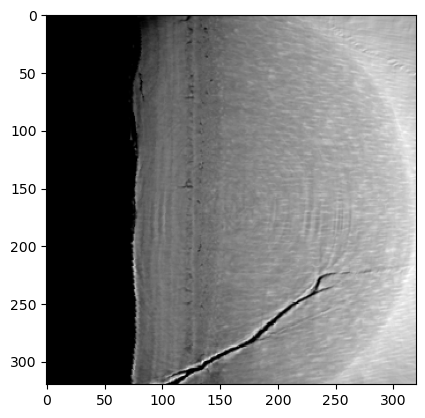

In [6]:
"""
Read in a straightened image

"""
import numpy as np
import matplotlib.pyplot as plt

image = np.load("straightened_image.npy")
plt.imshow(image, cmap="grey")

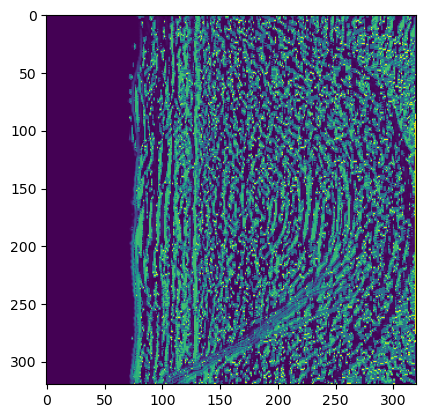

In [31]:
"""
Apply a steerable Gaussian filter to it

"""
from cementum import filter

filtered = filter.steerable_filter(image, 0, 0.7)

plt.imshow(filtered)